# Test ResNet

Use python v3.7.12 and sktime v0.4.1

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import GridSearchCV
from sktime.datasets import load_italy_power_demand
from sktime_dl.deeplearning import CNNClassifier

sns.set_style('whitegrid') 

## Grid Search

In [3]:
X_train, y_train = load_italy_power_demand(split='train', return_X_y=True)
X_test, y_test = load_italy_power_demand(split='test', return_X_y=True)

In [4]:
X_train.head()

,dim_0
0,0 -0.710520 1 -1.183300 2 -1.372400 3...
1,0 -0.993010 1 -1.426800 2 -1.579900 3...
2,0 1.319100 1 0.569770 2 0.195130 3...
3,0 -0.812440 1 -1.157600 2 -1.416400 3...
4,0 -0.972840 1 -1.390500 2 -1.536700 3...


In [5]:
y_train

array(['1', '1', '2', '2', '1', '1', '2', '1', '1', '2', '2', '1', '1',
       '2', '1', '2', '1', '1', '2', '1', '1', '2', '1', '1', '1', '1',
       '1', '2', '2', '1', '1', '2', '2', '1', '2', '2', '1', '2', '1',
       '2', '1', '1', '2', '2', '1', '2', '2', '2', '2', '1', '1', '2',
       '2', '2', '1', '2', '2', '1', '1', '2', '2', '1', '1', '2', '1',
       '2', '2'], dtype='<U1')

In [6]:
network = CNNClassifier(nb_epochs=200, verbose=False)
network.fit(X_train, y_train)
network.score(X_test, y_test)

2022-02-18 20:05:52.949815: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-02-18 20:05:52.949878: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-02-18 20:05:52.949917: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (pced): /proc/driver/nvidia/version does not exist
2022-02-18 20:05:52.951080: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


0.8036929057337221

In [7]:
param_grid = {'kernel_size': [7, 9],
              'avg_pool_size': [3, 5]}
grid = GridSearchCV(network, param_grid=param_grid, cv=5)   
grid.fit(X_train, y_train)
    
print("Best cross-validation accuracy: {:.2f}".format(grid.best_score_))
print("Test set score: {:.2f}".format(grid.score(X_test, y_test)))
print("Best parameters: {}".format(grid.best_params_))

/home/cjung/.pyenv/versions/3.7.12/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
10 fits failed out of a total of 20.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/home/cjung/.pyenv/versions/3.7.12/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/cjung/.pyenv/versions/3.7.12/lib/python3.7/site-packages/sktime_dl/deeplearning/cnn/_classifier.py", line 144, in fit
    self.model = self.build_model(self.input_shape, self.nb_classes)
  File "/home/cjung/.pyenv/versions/3.7.12/lib/python3.7/site-packages

Best cross-validation accuracy: 0.93
Test set score: 0.94
Best parameters: {'avg_pool_size': 3, 'kernel_size': 9}


In [ ]:
y_pred = grid.best_estimator_.predict(X_test)

In [12]:
from sklearn.metrics import accuracy_score

In [13]:
accuracy_score(y_test, y_pred)

0.9387755102040817

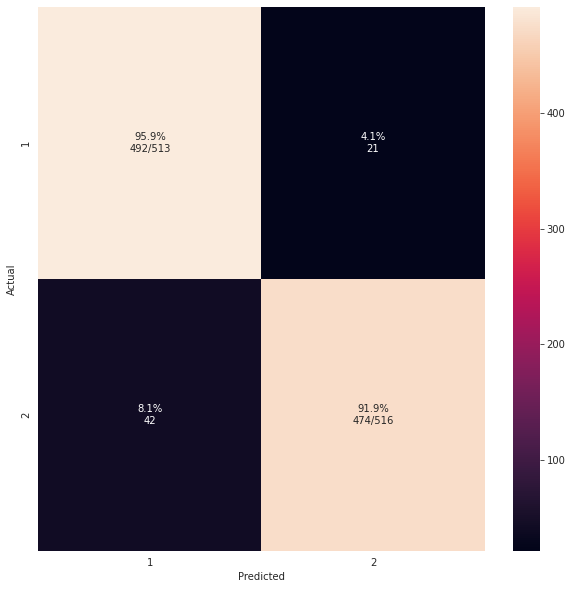

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.metrics import confusion_matrix

def cm_analysis(y_true, y_pred, labels, ymap=None, figsize=(10,10)):
    """
    Generate matrix plot of confusion matrix with pretty annotations.
    The plot image is saved to disk.
    args: 
      y_true:    true label of the data, with shape (nsamples,)
      y_pred:    prediction of the data, with shape (nsamples,)
      filename:  filename of figure file to save
      labels:    string array, name the order of class labels in the confusion matrix.
                 use `clf.classes_` if using scikit-learn models.
                 with shape (nclass,).
      ymap:      dict: any -> string, length == nclass.
                 if not None, map the labels & ys to more understandable strings.
                 Caution: original y_true, y_pred and labels must align.
      figsize:   the size of the figure plotted.
    """
    if ymap is not None:
        y_pred = [ymap[yi] for yi in y_pred]
        y_true = [ymap[yi] for yi in y_true]
        labels = [ymap[yi] for yi in labels]
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    cm_sum = np.sum(cm, axis=1, keepdims=True)
    cm_perc = cm / cm_sum.astype(float) * 100
    annot = np.empty_like(cm).astype(str)
    nrows, ncols = cm.shape
    for i in range(nrows):
        for j in range(ncols):
            c = cm[i, j]
            p = cm_perc[i, j]
            if i == j:
                s = cm_sum[i]
                annot[i, j] = '%.1f%%\n%d/%d' % (p, c, s)
            elif c == 0:
                annot[i, j] = ''
            else:
                annot[i, j] = '%.1f%%\n%d' % (p, c)
    cm = pd.DataFrame(cm, index=labels, columns=labels)
    cm.index.name = 'Actual'
    cm.columns.name = 'Predicted'
    fig, ax = plt.subplots(figsize=figsize)
    sns.heatmap(cm, annot=annot, fmt='', ax=ax)
    #plt.savefig(filename)
    plt.show()

cm_analysis(y_test, y_pred, network.classes_, ymap=None, figsize=(10,10))